# Lab 10
## Submitted By: Aagnay Kariyal
## Student ID: 8830232

***


In [1]:
import os, shutil, pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

In [2]:
main_dir = '/Users/aagnaykariyal/Documents/Github/Conestoga/CSCN8010/data/archive'
train_dir = os.path.join(main_dir, 'train')
valid_dir = os.path.join(main_dir, 'valid')
test_dir = os.path.join(main_dir, 'test')

In [3]:
names = sorted([x for x in os.listdir(train_dir)])
counts = [len(os.listdir(os.path.join(train_dir, x))) for x in names]
classes = np.argsort(counts)[-3:]
class_names = [names[id] for id in classes]
print(class_names)    

NotADirectoryError: [Errno 20] Not a directory: '/Users/aagnaykariyal/Documents/Github/Conestoga/CSCN8010/data/archive/train/.DS_Store'

In [4]:
# Creating new folders consisting of just the 3 classes
new_train = os.path.join(main_dir, "new_train")
new_test = os.path.join(main_dir, "new_test")
new_valid = os.path.join(main_dir, "new_valid")
os.makedirs(new_train, exist_ok=True)
os.makedirs(new_test, exist_ok=True)
os.makedirs(new_valid, exist_ok=True)
for name in class_names:
    os.rename(os.path.join(train_dir, name),os.path.join(new_train, name))
    os.rename(os.path.join(valid_dir, name),os.path.join(new_valid, name))
    os.rename(os.path.join(test_dir, name), os.path.join(new_test, name))

NameError: name 'class_names' is not defined

In [5]:
main_dir = pathlib.Path(main_dir)
train = image_dataset_from_directory(
    main_dir/"new_train",
    image_size=(224, 224),
    batch_size=32)
test = image_dataset_from_directory(
    main_dir/"new_test",
    image_size=(224, 224),
    batch_size=32)
valid = image_dataset_from_directory(
    main_dir/"new_valid",
    image_size=(224, 224),
    batch_size=32)

Found 744 files belonging to 3 classes.


2023-12-14 07:51:11.267233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-14 07:51:11.267275: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-14 07:51:11.267302: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-14 07:51:11.267684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 07:51:11.267976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [4]:
# define a function to augment data
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), # changed the percentages a little
        layers.RandomZoom(0.3),
    ]
)

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape = (224,224,3)
)

In [6]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               642278

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/vgg16_bird_classifier.tf",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train,
    epochs=10,
    validation_data=valid,
    callbacks=callbacks
)

Epoch 1/10


2023-12-03 11:09:30.447094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 138.0965 - accuracy: 0.8548INFO:tensorflow:Assets written to: ./models/vgg16_bird_classifier.tf/assets


INFO:tensorflow:Assets written to: ./models/vgg16_bird_classifier.tf/assets


24/24 [==============================] - 38s 1s/step - loss: 138.0965 - accuracy: 0.8548 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 26s 1s/step - loss: 20.5609 - accuracy: 0.9610 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 29s 1s/step - loss: 2.3908 - accuracy: 0.9919 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 30s 1s/step - loss: 1.1887 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 33s 1s/step - loss: 3.4364 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 25s 1s/step - loss: 1.2719 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 0.7529 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


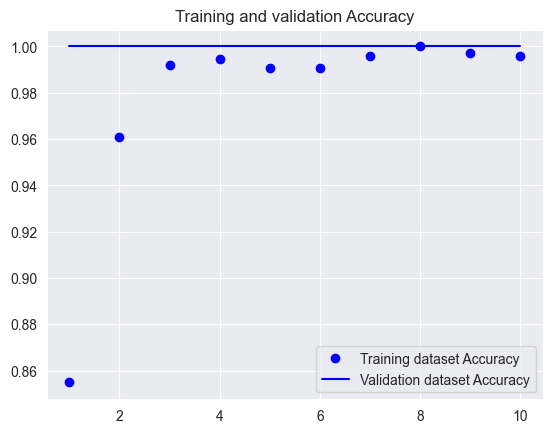

<Figure size 640x480 with 0 Axes>

In [10]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training dataset Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation dataset Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()
plt.show()

def preprocess(dataset):
    features = []
    labels = []
    for i, l in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(i)
        feat = conv_base.predict(preprocessed_images)
        features.append(feat)
        labels.append(labels)
    data = np.concatenate(features), np.concatenate(labels)
    return data

train_features, train_labels =  preprocess(train)
val_features, val_labels =  preprocess(valid)
test_features, test_labels =  preprocess(test)

In [14]:
classes = []
for features, labels in valid:
    preprocessed_images = keras.applications.vgg16.preprocess_input(features)
    features = conv_base.predict(preprocessed_images)
    classes.append(labels)

y_pred = model.predict(classes)
pred = np.argmax(y_pred, axis=1)
cf_matrix = tf.math.confusion_matrix(classes, pred)
print(cf_matrix)

1/1 [==============================] - 0s 30ms/step


ValueError: in user code:

    File "/Users/aagnaykariyal/Documents/Github/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/Users/aagnaykariyal/Documents/Github/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aagnaykariyal/Documents/Github/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/aagnaykariyal/Documents/Github/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/Users/aagnaykariyal/Documents/Github/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'tf.nn.bias_add' (type TFOpLambda).
    
    Shape must be at least rank 2 but is rank 1 for '{{node model/tf.nn.bias_add/BiasAdd}} = BiasAdd[T=DT_FLOAT, data_format="NHWC"](model/tf.__operators__.getitem/strided_slice, model/tf.nn.bias_add/BiasAdd/bias)' with input shapes: [?], [3].
    
    Call arguments received by layer 'tf.nn.bias_add' (type TFOpLambda):
      • value=tf.Tensor(shape=(None,), dtype=float32)
      • bias=tf.Tensor(shape=(3,), dtype=float32)
      • data_format='NHWC'
      • name=None
